In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

from skimage.transform import resize

from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.layers import *
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.models import load_model
from keras.models import model_from_json
import random

seed = 42
np.random.seed = seed


Using TensorFlow backend.


Loading images

In [0]:
IMG_WIDTH = 512
IMG_HEIGHT = 1024
IMG_CHANNELS = 1 # grayscale images

# paths to image folders (train, test)
#train_images_path='/content/drive/My Drive/Colab Notebooks/MICCAI/train'
#train_masks_path='/content/drive/My Drive/Colab Notebooks/MICCAI/mask'
train_images_path='/content/drive/My Drive/Colab Notebooks/fluids/train_images'
train_masks_path='/content/drive/My Drive/Colab Notebooks/fluids/train_masks'
test_images_path='/content/drive/My Drive/Colab Notebooks/fluids/test_images'
test_masks_path='/content/drive/My Drive/Colab Notebooks/fluids/test_masks'

In [0]:
# reading images and masks 
# fuction return values of images as array [number of images, image_height, image_width, img_channels]

def load_data (path_img, path_mask, total):
  m=os.listdir(path_img) # list of train images
  img = np.zeros((total, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
  mask = np.zeros((total, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
  for i in range (0, total):
   img_sample = cv2.imread(path_img + '/' + m[i], 0) / 255. # 0 stands for grayscale images, normalize by dividing with 255
   #img_sample = cv2.resize(img_sample, dsize=(IMG_HEIGHT, IMG_WIDTH), interpolation=cv2.INTER_CUBIC)
   img[i] = np.reshape(img_sample, (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
   mask_sample = cv2.imread(path_mask + '/' + m[i], 0)
   mask_sample [mask_sample > 1] =1 # converts class 2 and 3 to 1 => binary case: class 0 (background) and 1 (fluid)
   #mask_sample = cv2.resize(mask_sample, dsize=(IMG_HEIGHT, IMG_WIDTH), interpolation=cv2.INTER_CUBIC)
   mask[i] = np.reshape(mask_sample, (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
  return img, mask

In [0]:
total = 1000
train_images, train_mask = load_data (train_images_path, train_masks_path, total)

In [0]:
total = 223
test_images, test_mask = load_data (test_images_path, test_masks_path, total)

Plotting images

In [0]:
# colour definition
yellow=np.array([255,255, 0])
red=np.array([255,0, 0]) 
blue=np.array([0,0, 255])
white=np.array([255,255,255])

# function which trasform mask values 0,1,2,3 into colours
def num_to_colors (mask, height, width):
    col_mask = np.zeros((height, width, 3))
    for j in range (0,width):
        for i in range (0,height):
            if (mask[i,j]==1):
                col_mask[i,j]=white
            elif (mask[i,j]==2):
                col_mask[i,j]=red 
            elif (mask[i,j]==3):
                col_mask[i,j]=yellow
           
    return col_mask


Image id: 4 patient10 (9).png



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


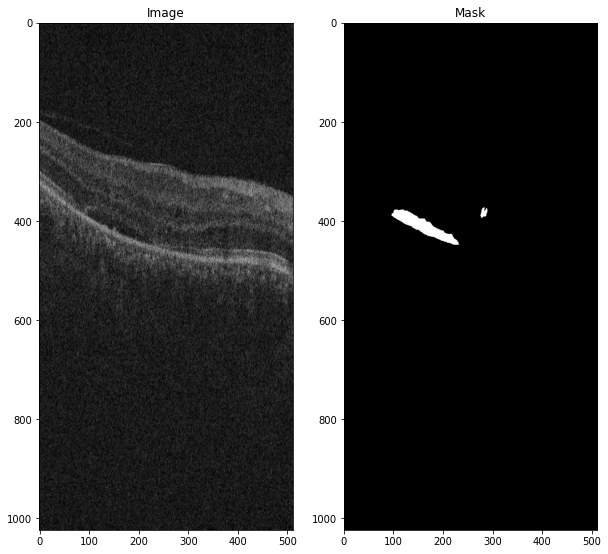

In [7]:
#plotting images
m=os.listdir(train_images_path)
#i = np.random.randint(0, len(m))
i = np.random.randint(0, 10)
print('Image id:',i ,  m[i])
print()
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.title('Image')
train = np.reshape(train_images[i], (IMG_HEIGHT, IMG_WIDTH))
plt.imshow(train, cmap='gray', vmin=0, vmax=1)
plt.subplot(1, 2, 2)
plt.title('Mask')
mask = np.reshape(train_mask[i], (IMG_HEIGHT, IMG_WIDTH))
mask = num_to_colors (mask, IMG_HEIGHT, IMG_WIDTH)

plt.imshow(mask)
plt.show()


Defining the model

In [0]:

def dice_coef(y_true, y_pred, smooth = 1.):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


# averaging across batch axis, 0-dimension
#def dice_coef(y_true, y_pred, smooth=1.):
   # intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    #union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    #return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)


def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [0]:
K.set_image_data_format('channels_last')  # TF dimension ordering in this code

In [0]:
def get_unet():
   
    
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    #conv1 = Dropout(0.1)(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu',  padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu',  padding='same')(pool1)
    #conv2 = Dropout(0.1)(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu',  padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu',  padding='same')(pool2)
    #conv3 = Dropout(0.2)(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu',  padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    #conv4 = Dropout(0.2)(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu',  padding='same')(pool4)
    #conv5 = Dropout(0.3)(conv5)
    conv5 = Conv2D(512, (3, 3), activation='relu',  padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu',  padding='same')(up6)
    #conv6 = Dropout(0.2)(conv6)
    conv6 = Conv2D(256, (3, 3), activation='relu',  padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu',   padding='same')(up7)
    #conv7 = Dropout(0.2)(conv7)
    conv7 = Conv2D(128, (3, 3), activation='relu',  padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    #conv8 = Dropout(0.1)(conv8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu',  padding='same')(up9)
    #conv9 = Dropout(0.1)(conv9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    out = Conv2D(1, (1, 1), activation='sigmoid')(conv9)
    
    model = Model(inputs=[inputs], outputs=[out])
    #model.compile(optimizer=Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])
    #model.compile(optimizer=Adam(lr=1e-5), loss='binary_crossentropy', metrics=[dice_coef])
    
    return model


In [0]:
model=get_unet()

In [0]:
#### in case of transfer learning - loading model
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
loaded_model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])

In [0]:
#tf.keras.utils.plot_model(model, show_shapes=True)

In [0]:
model_checkpoint = ModelCheckpoint('weights.hdf5', monitor='val_loss', save_best_only=True)
model=loaded_model #kod TL model change to loaded_model
model_history = model.fit(train_images, train_mask, batch_size=4, epochs=40, verbose=1, shuffle=True,
              validation_split=0.1,
              callbacks = [model_checkpoint])

Train on 900 samples, validate on 100 samples
Epoch 1/40
900/900 [==============================] - 308s 343ms/step - loss: 0.3192 - dice_coef: 0.6808 - val_loss: 0.2944 - val_dice_coef: 0.7056
Epoch 2/40
304/900 [=========>....................] - ETA: 3:16 - loss: 0.3326 - dice_coef: 0.6674

In [0]:
0# for transfer learning, saving model for later use
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")


In [0]:
#model.save('Model_miccai_dice.h5')
#model.save_weights('weights_miccai.hdf5')

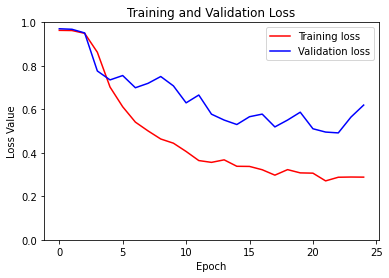

In [0]:
# Plotting loss and validation loss
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(150)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()



In [0]:
# smoothing the curve
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points


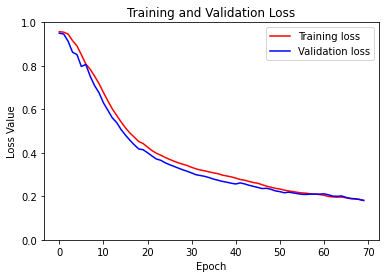

In [0]:
#Plotting smooth version of loss
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(70)

plt.figure()
plt.plot(epochs, smooth_curve (loss), 'r', label='Training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()


Predictions for test images

In [0]:
model=loaded_model # for TL
pred_mask = np.zeros((20, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
pred_mask = model.predict(test_images[:20]) 


In [0]:
k=os.listdir(test_images_path)
print(k[2])

In [0]:
# output is sigmoid function, treshold is put to 0.5
# to see which treshold is best
pred_mask_tresh = np.zeros((20, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
pred_mask_tresh[pred_mask>0.5] = 1

In [0]:
def show_predictions (i, pred_mask):
  m=os.listdir(train_images_path)
  print('Image id:',i,  m[i])
  print()
  plt.figure(figsize=(10, 10))
  plt.subplot(1, 3, 1)
  plt.title('Image')
  train = np.reshape(train_images[i], (IMG_HEIGHT, IMG_WIDTH))
  plt.imshow(train, cmap='gray', vmin=0, vmax=1)
  plt.subplot(1, 3, 2)
  plt.title('Mask')
  mask = np.reshape(train_mask[i], (IMG_HEIGHT, IMG_WIDTH))
  mask = num_to_colors (mask, IMG_HEIGHT, IMG_WIDTH)
  plt.imshow(mask)
  plt.subplot(1, 3, 3)
  plt.title('Predicted')
  predicted_mask = pred_mask_tresh[i]
  predicted_mask = np.reshape (predicted_mask, (IMG_HEIGHT, IMG_WIDTH))
  predicted_mask = num_to_colors(predicted_mask, IMG_HEIGHT, IMG_WIDTH)
  plt.imshow(predicted_mask)
  plt.show()
 

In [0]:
#i = np.random.randint(0, 20)
# i=4, 9, 11, 16
i= 2
show_predictions(i, pred_mask[i])

Calculating DICE for test dataset

In [0]:
temp=pred_mask[i]
temp [temp > 0.5] =1
print(np.histogram(temp))

In [0]:
test_mask_f=np.zeros((223, IMG_HEIGHT*IMG_WIDTH)) #223 is number of test images
pred_mask_f=np.zeros((223, IMG_HEIGHT*IMG_WIDTH))
pred_mask=np.zeros((223, IMG_HEIGHT, IMG_WIDTH))
dice=np.zeros(223)
for i in range(0,223):
  pred_mask[i] = np.reshape(model.predict(test_images[i:i+1]), (IMG_HEIGHT, IMG_WIDTH)) #loaded_model for TL
  test_mask_f[i]=test_mask[i].flatten()
  pred_mask_f[i]=pred_mask[i].flatten()
  temp=pred_mask_f[i]
  temp[temp> 0.5]=1
  intersection = K.sum(test_mask_f[i] * temp)
  dice[i] = (2. * intersection + 1.) / (K.sum(test_mask_f[i]) + K.sum(temp) + 1.)
  #print(dice[i]) 

In [0]:
print('DICE mean:',np.mean(dice), 'std:', np.std(dice))

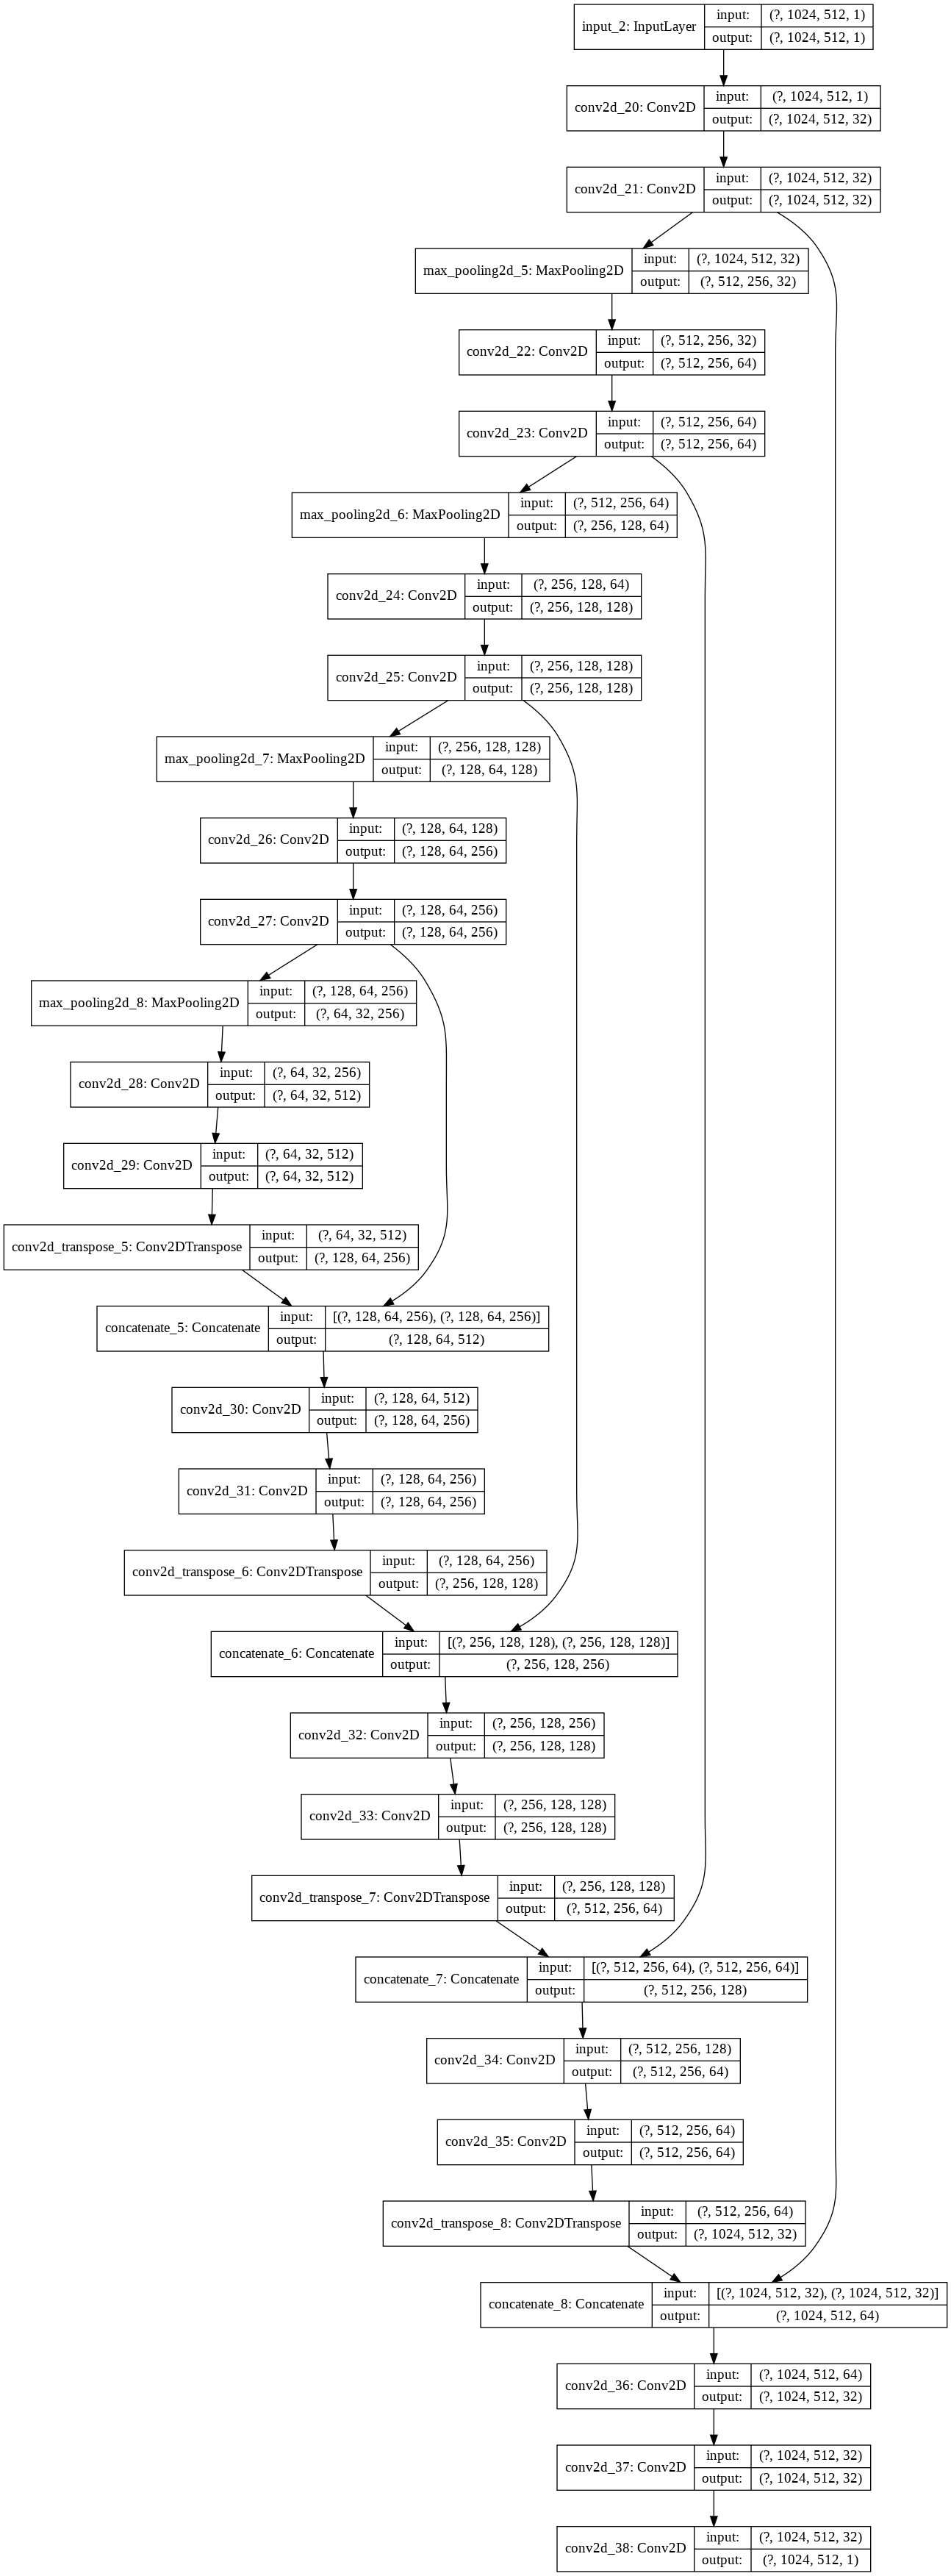

In [0]:
tf.keras.utils.plot_model(model, show_shapes=True)

Visualizing convnet filters



In [0]:
def deprocess_image(x):
  x -= x.mean()
  x /= (x.std() + 1e-5)
  x *= 0.1
  x += 0.5
  x = np.clip(x, 0, 1)
  x *= 255
  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [0]:
def generate_pattern(layer_name, filter_index, size=64):
  layer_output = model.get_layer(layer_name).output
  loss = K.mean(layer_output[:, :, :, filter_index])
  grads = K.gradients(loss, model.input)[0]
  grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
  iterate = K.function([model.input], [loss, grads])
  input_img_data = np.random.random((1, size, size, 1)) * 20 + 128.
  step = 1.
  for i in range(40):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step
    img = input_img_data[0]
    img = np.reshape(img, (size, size))
  return deprocess_image(img)

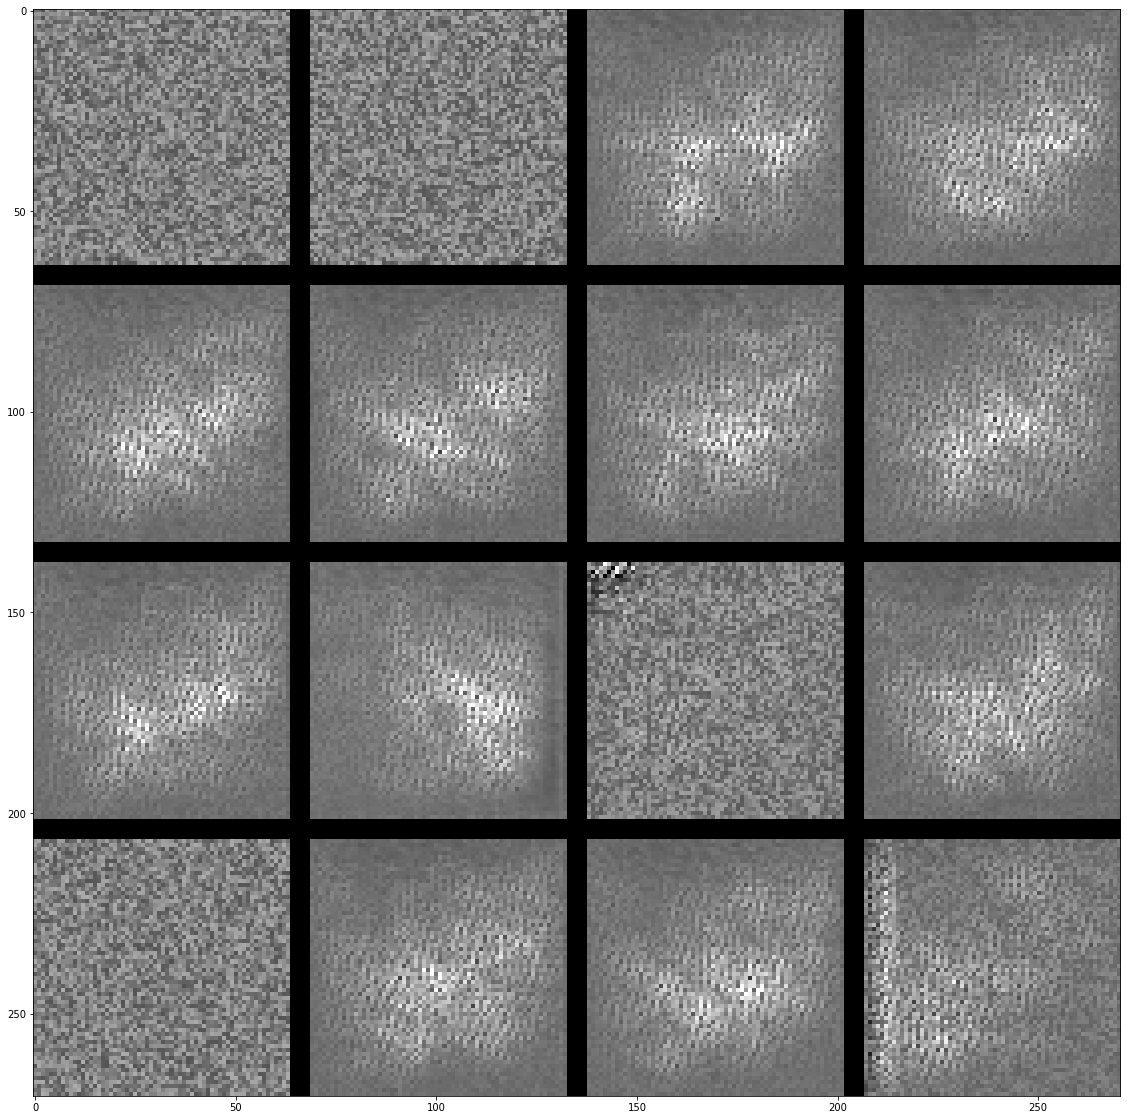

In [0]:
from keras import backend as K
# model=loaded_model for TL
# conv2d_ 2  4, 7  10  13 16
layer_name = 'conv2d_35'
size = 64
margin = 5
results = np.zeros((4 * size + 3 * margin, 4 * size + 3 * margin))

for i in range(4):
  for j in range(4):
    filter_img = generate_pattern(layer_name, i+(j*4), size=size)
    filter_img = np.reshape(filter_img, (size, size))
    horizontal_start = i * size + i * margin
    horizontal_end = horizontal_start + size
    vertical_start = j * size + j * margin
    vertical_end = vertical_start + size
    results[horizontal_start: horizontal_end, vertical_start: vertical_end] = filter_img

plt.figure(figsize=(20, 20))
plt.imshow(results, cmap='gray')

In [0]:
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1024, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 1024, 512, 32 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 1024, 512, 32 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 512, 256, 32) 0           conv2d_2[0][0]                   
____________________________________________________________________________________________